In [ ]:
!pip install tensorflow
!pip install tensorflow-model-optimization
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install google-colab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.9 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted and results directory created at /content/drive/My Drive/Model_Comparison_Results
Processing dataset: cifar10
Training and evaluating on dataset: cifar10
Loading dataset: cifar10
Dataset cifar10 loaded successfully
Creating model...
Creating lightweight model with input shape (32, 32, 3) and 10 classes
Compiling model...
Starting training...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - accuracy: 0.1302 - loss: 2.2753 - val_accuracy: 0.1934 - val_loss: 2.1691
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.2246 - loss: 2.1212 - val_accuracy: 0.1798 - val_loss: 2.1121
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.2579 - loss: 1.9852 - val_accuracy: 0.1751 - val_loss: 2.2394
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.2806 - loss: 1.9185 - val_accuracy: 0.2873 - val

Saving uncompressed model to /content/drive/My Drive/Model_Comparison_Results/cifar10_model.h5
Converting model to TFLite format and saving to /content/drive/My Drive/Model_Comparison_Results/cifar10_model.tflite
Saved artifact at '/tmp/tmpgztr1l02'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140511284222912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511284225024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511284227664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511284229424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511284222736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511284228192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511284230656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511284231

Saving uncompressed model to /content/drive/My Drive/Model_Comparison_Results/mnist_model.h5
Converting model to TFLite format and saving to /content/drive/My Drive/Model_Comparison_Results/mnist_model.tflite
Saved artifact at '/tmp/tmpf1n8e6mk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_9')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140511447024384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511320555216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511320543952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511320553808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511320550464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511320555040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511320543248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14051132055451

Saving uncompressed model to /content/drive/My Drive/Model_Comparison_Results/fashion_mnist_model.h5
Converting model to TFLite format and saving to /content/drive/My Drive/Model_Comparison_Results/fashion_mnist_model.tflite
Saved artifact at '/tmp/tmp5es0y7nq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140511318253360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511316971536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511867837024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511316971184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511316968720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511316977168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140511316971008: TensorSpec(shape=(), dtype=tf.resource, name=None)

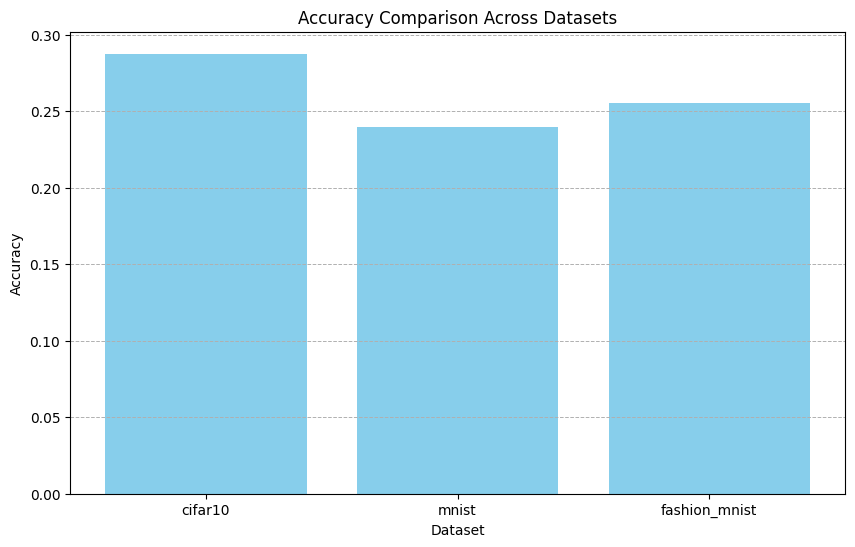

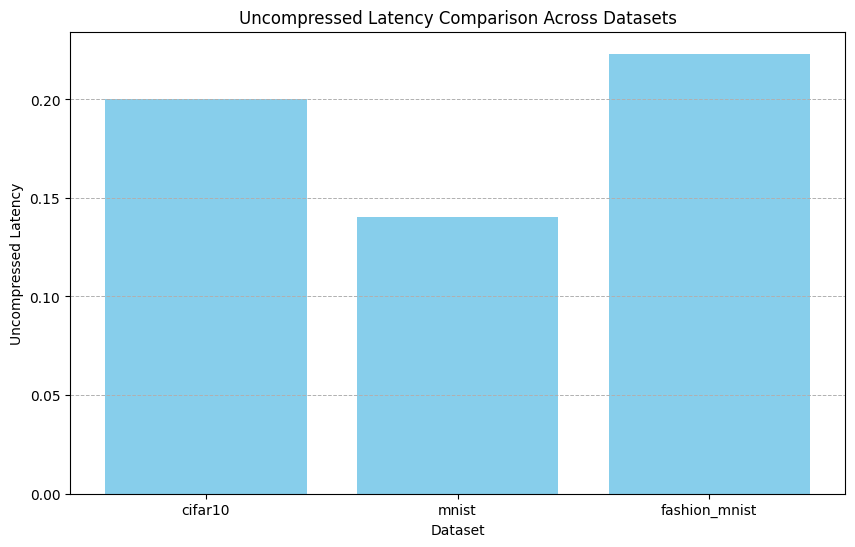

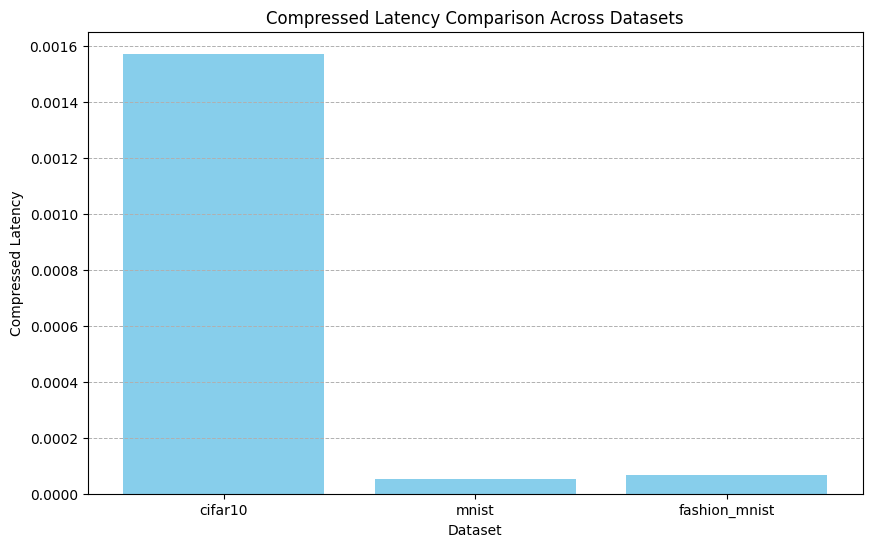

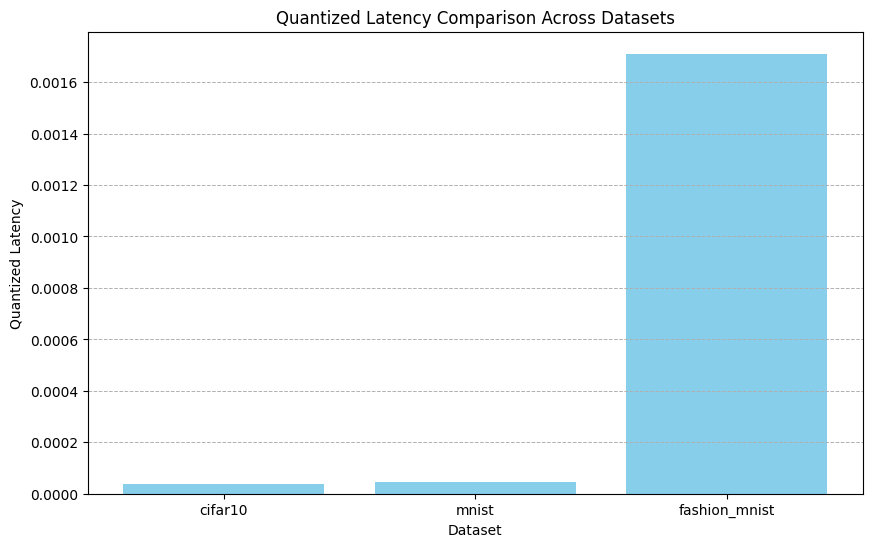

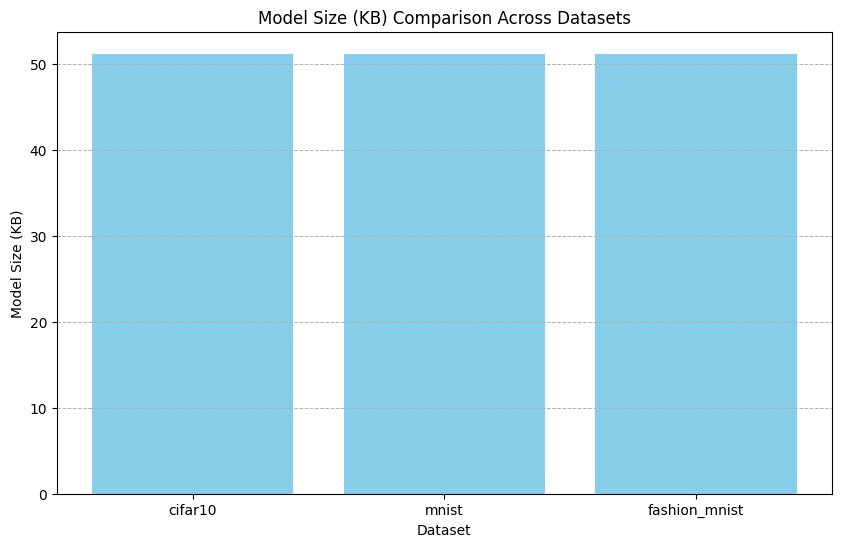

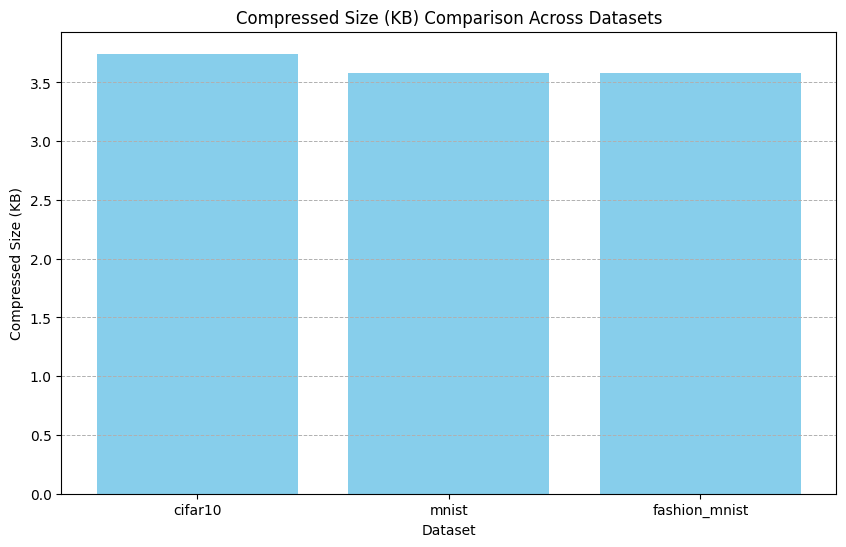

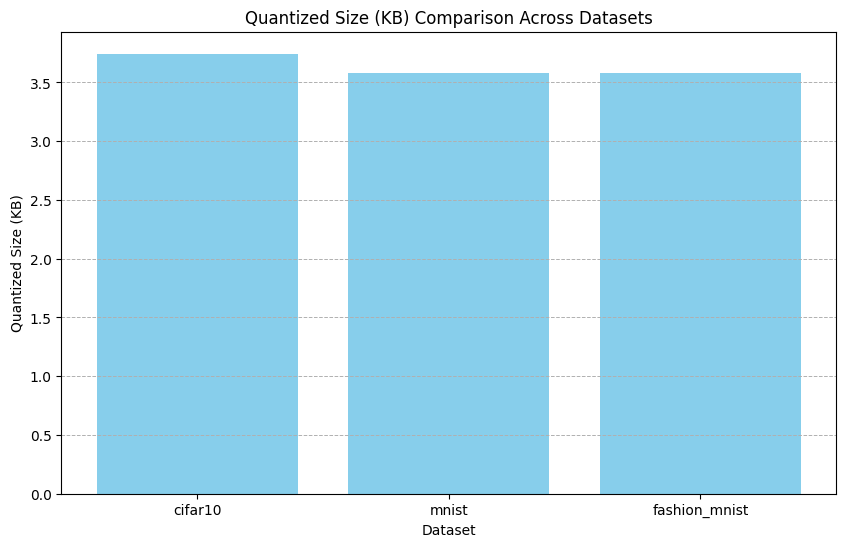

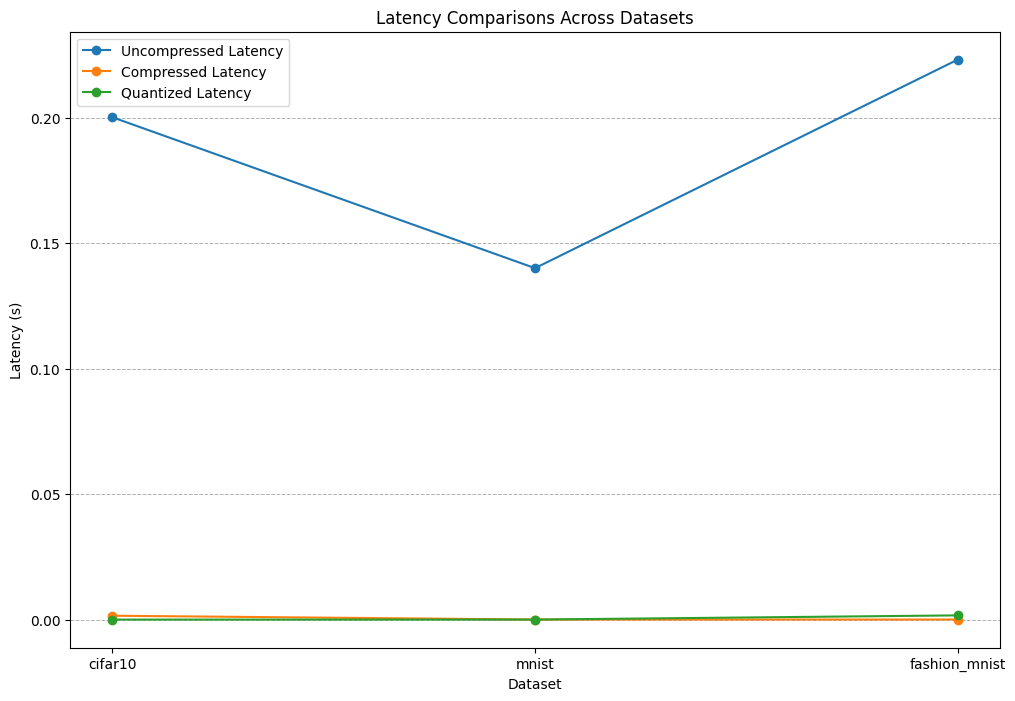

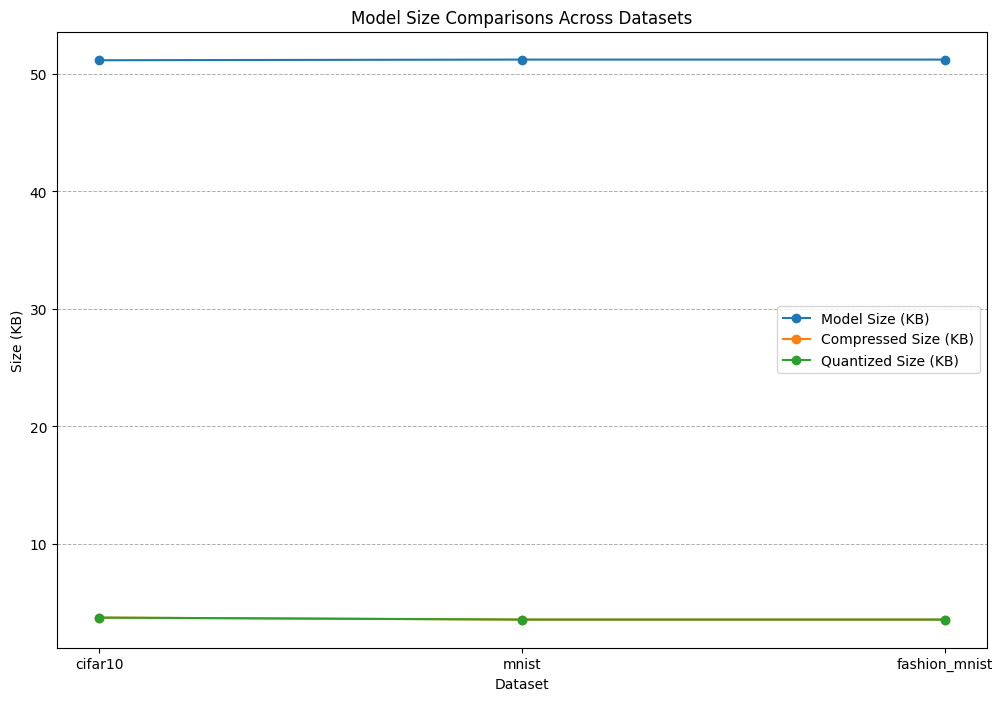

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude, strip_pruning

# Mount Google Drive
drive.mount('/content/drive')
RESULTS_DIR = "/content/drive/My Drive/Model_Comparison_Results"
os.makedirs(RESULTS_DIR, exist_ok=True)
print("Google Drive mounted and results directory created at", RESULTS_DIR)

# Function to create a lightweight model
def create_lightweight_model(input_shape, num_classes):
    print(f"Creating lightweight model with input shape {input_shape} and {num_classes} classes")
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        DepthwiseConv2D(kernel_size=3, strides=1, padding='same'),
        BatchNormalization(),
        ReLU(),
        DepthwiseConv2D(kernel_size=3, strides=2, padding='same'),
        BatchNormalization(),
        ReLU(),
        GlobalAveragePooling2D(),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Dataset loaders
def load_dataset(name):
    print(f"Loading dataset: {name}")
    if name == 'cifar10':
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        input_shape = (32, 32, 3)
        num_classes = 10
    elif name == 'mnist':
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        x_train = x_train[..., np.newaxis]
        x_test = x_test[..., np.newaxis]
        input_shape = (28, 28, 1)
        num_classes = 10
    elif name == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
        x_train = x_train[..., np.newaxis]
        x_test = x_test[..., np.newaxis]
        input_shape = (28, 28, 1)
        num_classes = 10
    elif name == 'tiny_imagenet':
        input_shape = (64, 64, 3)
        num_classes = 200
        print("Tiny ImageNet dataset preprocessing is a placeholder.")
        (x_train, y_train), (x_test, y_test) = (None, None), (None, None)
    else:
        raise ValueError("Unsupported dataset")

    x_train, x_test = x_train / 255.0, x_test / 255.0
    print(f"Dataset {name} loaded successfully")
    return (x_train, y_train), (x_test, y_test), input_shape, num_classes

# Training and evaluation function
def train_and_evaluate(dataset_name, epochs, batch_size):
    print(f"Training and evaluating on dataset: {dataset_name}")
    (x_train, y_train), (x_test, y_test), input_shape, num_classes = load_dataset(dataset_name)

    print("Creating model...")
    model = create_lightweight_model(input_shape, num_classes)

    print("Compiling model...")
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print("Starting training...")
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)

    uncompressed_model_path = f"{RESULTS_DIR}/{dataset_name}_model.h5"
    print(f"Saving uncompressed model to {uncompressed_model_path}")
    model.save(uncompressed_model_path)

    tflite_model_path = f"{RESULTS_DIR}/{dataset_name}_model.tflite"
    print(f"Converting model to TFLite format and saving to {tflite_model_path}")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    # Quantized Model
    quantized_model_path = f"{RESULTS_DIR}/{dataset_name}_quantized_model.tflite"
    print(f"Applying quantization and saving to {quantized_model_path}")
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantized_model = converter.convert()
    with open(quantized_model_path, 'wb') as f:
        f.write(quantized_model)

    # Latency evaluation
    print("Evaluating latency for uncompressed model")
    uncompressed_latency = evaluate_latency(model, x_test[:1])
    print("Evaluating latency for compressed model")
    compressed_latency = evaluate_tflite_latency(tflite_model_path, x_test[:1])
    print("Evaluating latency for quantized model")
    quantized_latency = evaluate_tflite_latency(quantized_model_path, x_test[:1])

    results = {
        'Dataset': dataset_name,
        'Accuracy': max(history.history['val_accuracy']),
        'Uncompressed Latency': uncompressed_latency,
        'Compressed Latency': compressed_latency,
        'Quantized Latency': quantized_latency,
        'Model Size (KB)': os.path.getsize(uncompressed_model_path) / 1024,
        'Compressed Size (KB)': os.path.getsize(tflite_model_path) / 1024,
        'Quantized Size (KB)': os.path.getsize(quantized_model_path) / 1024
    }
    print(f"Results for {dataset_name}: {results}")
    return results

# Latency evaluation functions
def evaluate_latency(model, sample):
    sample = sample.astype(np.float32)  # Ensure the input data is in the correct type
    start_time = time.time()
    _ = model.predict(sample)
    latency = time.time() - start_time
    return latency

def evaluate_tflite_latency(tflite_path, sample):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_data = sample.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    start_time = time.time()
    interpreter.invoke()
    latency = time.time() - start_time
    return latency

# Main script
datasets = ['cifar10', 'mnist', 'fashion_mnist']
all_results = []

for dataset in datasets:
    print(f"Processing dataset: {dataset}")
    results = train_and_evaluate(dataset, epochs=10, batch_size=64)
    all_results.append(results)

# Save results to CSV
results_df = pd.DataFrame(all_results)
csv_path = f"{RESULTS_DIR}/model_comparison_results.csv"
results_df.to_csv(csv_path, index=False)

# Generate graphs
for metric in ['Accuracy', 'Uncompressed Latency', 'Compressed Latency', 'Quantized Latency', 'Model Size (KB)', 'Compressed Size (KB)', 'Quantized Size (KB)']:
    plt.figure(figsize=(10, 6))
    plt.bar(results_df['Dataset'], results_df[metric], color='skyblue')
    plt.title(f'{metric} Comparison Across Datasets')
    plt.ylabel(metric)
    plt.xlabel('Dataset')
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    graph_path = f"{RESULTS_DIR}/{metric}_comparison.png"
    plt.savefig(graph_path)
    plt.show()

# Additional comparisons
comparison_metrics = ['Uncompressed Latency', 'Compressed Latency', 'Quantized Latency']
plt.figure(figsize=(12, 8))
for metric in comparison_metrics:
    plt.plot(results_df['Dataset'], results_df[metric], marker='o', label=metric)
plt.title('Latency Comparisons Across Datasets')
plt.ylabel('Latency (s)')
plt.xlabel('Dataset')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.7)
latency_graph_path = f"{RESULTS_DIR}/Latency_comparison_line_plot.png"
plt.savefig(latency_graph_path)
plt.show()

# Model size comparisons
size_metrics = ['Model Size (KB)', 'Compressed Size (KB)', 'Quantized Size (KB)']
plt.figure(figsize=(12, 8))
for metric in size_metrics:
    plt.plot(results_df['Dataset'], results_df[metric], marker='o', label=metric)
plt.title('Model Size Comparisons Across Datasets')
plt.ylabel('Size (KB)')
plt.xlabel('Dataset')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.7)
size_graph_path = f"{RESULTS_DIR}/Model_Size_comparison_line_plot.png"
plt.savefig(size_graph_path)
plt.show()
